## Chapter 12-2. Beta Hedging and the Art of Not Following the Market

## Beta Hedging

### Factor Model (여러개의 다른 beta 를 가진 자산 porfolio 구성)

$$Y = \alpha + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n$$

ex) $Y_{TSLA} = \alpha + \beta X_{SPY} + \beta X_{AAPL}$  두개의 beta 중 하나는 TSLA 의 SPY 에 대한 beta 이고 다른 하나는 AAPL 에 대한 beta 이다.

#### $\beta$ 는 Risk Exposure 라고 부른다. 우리가 Factor Model 을 잘 구성해서 $\beta$ 를 0 로 만들 수 있으면 $\alpha$는 constant 이므로 어떠한 상황에서도 일정한 수익을 지속적으로 얻을 수 있다. 반대로 $\beta$ 가 크면 market 의 변동성에 그대로 노출되므로 특별한 전략이 필요 없고 ETF(Exchange Traded Fund) 같은 high $\beta$ 상품을 사는 것과 다를 바 없다. 이 것은 투자자들이 원하는 것이 아니다. high beta 전략이 시장이 좋을때는 매력적으로 보일 수 있으나 장기적으로 시장 하락시에 극단적 손실을 당하게 된다.

#### Risk Management 의 두가지 방법
* diversification
* hedging - 동일한 beta 를 가진 자산을 short 하면 pure alpha 만 남는다.

#### $\beta$ 는 moving target 이고 timeframe 변화에 따라 항상 변하므로 완벽히 $\beta$ 를 0 로 만들 수는 없고 부분적으로 감소시킬 뿐이다.

#### $\beta$ 를 0 로 만들면 당연히 수익률도 $\alpha$ 수준으로 낮아지지만 leverage 를 높여서 수익을 크게 만들 수 있다.
#### 또다른 이점은 $\beta$ 를 0 에 가깝게 만들면 volatility 가 낮아지고 Sharpe Ratio 가 높아지는 것이다. 

#### Volatility 와 Risk Exposure 가 줄어들면 확신을 가지고 leverage 를 올릴 수 있다. (borrow the money 혹은 투자자 유치)

#### Pairs Trading 은 industry standard 한 hedging 기법이다. 20-30 개의 서로 다른 beta 를 가진 종목을 자기만의 방식으로 rank 를 매겨서 상위 p %  종목은 long 하고 하위 p% 종목은 short 하여 전체 beta 를 0 에 가깝게 만드는 것이다. 돈을 버는 것은 상위 종목들이 하위 종목들 보다 better performance 를 낼 때 spread 만큼 버는 것이다. Implement 도 단순하고 핵심은 ranking system 이다.

In [35]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import pandas as pd
from googlefinance.client import get_price_data, get_prices_data

In [36]:
param_TSLA = {'q': "TSLA",  'i': "86400",  'x': "NASD",  'p': "10Y" }
df = pd.DataFrame(get_price_data(param_TSLA))
df.index = df.index.date
df.index = pd.to_datetime(df.index)

start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2015-01-01')

asset = df['Close'].loc[start : end]

params_SPY = [{'q': ".INX", 'x': "INDEXSP"}]
period = "10Y"
df = get_prices_data(params_SPY, period)
df.index = pd.to_datetime(df.index)

start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2015-01-01')

benchmark = df['.INX_Close'].loc[start : end]    

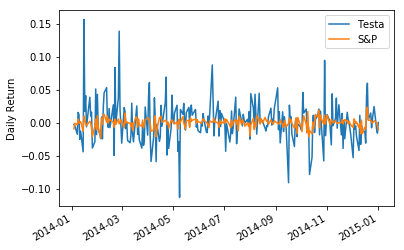

In [37]:
# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

# Let's plot them just for fun
r_a.plot()
r_b.plot()
plt.ylabel("Daily Return")
plt.legend(['Testa', 'S&P']);

Now we can perform the regression to find $\alpha$ and $\beta$:

In [38]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the date
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

alpha: 0.00114536515242
beta: 1.90074406257


If we plot the line $\alpha + \beta X$, we can see that it does indeed look like the line of best fit:

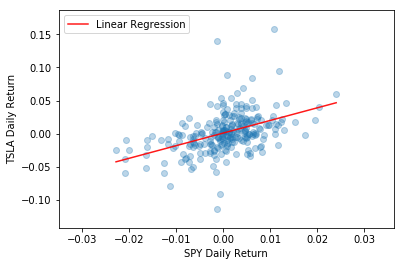

In [39]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("TSLA Daily Return")

 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9, label='Linear Regression')
plt.legend();

# Implementing hedging

이제 얼마나 hedge 해야 하는지 알았으므로 hedge 가 수익율에 미치는 영향을 보자. asset 과 benchmark 두개로 portfolio 를 구성하고 benchmark 를
$-\beta$ 로 비중을 주겠다.

asset(Tesla) = $\alpha$ + $\beta *$ benchmark(SPY) 이므로, portfolio = -1\* $\beta$ * benchmark(SPY) + asset(Tesla) 로  구성하면,

portfolio = Tesla - beta * benchmark = $\alpha$ 가 되어 alpha 만 남는다. 즉, Tesla 의 volatility 가 제거되었다.

### Construct a portfolio with beta hedging

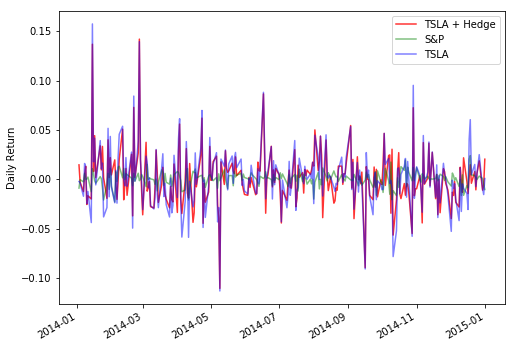

In [40]:
# Construct a portfolio with beta hedging
portfolio = -1*beta*r_b + r_a    # r_b : benchmark, r_a : asset
portfolio.name = "TSLA + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
plt.figure(figsize=(8,6))
portfolio.plot(alpha=0.9, color='red')
r_b.plot(alpha=0.5, label='S&P', color='green');
r_a.plot(alpha=0.5, label='TSLA', color='blue');

plt.ylabel("Daily Return")
plt.legend();

위 plot 에서 portfolio 의 return 은 asset(Tesla) 단독 return 과 거의 유사해 보인다. 두개의 평균 return 과 volatility (std of returns) 를 계산하고 차이를 계량화 할 수 있다. asset 과 porfolio 의 mean return 과 volatility 가 거의 유사하다.

In [41]:
print("means return of portfolio vs. TESLA : ", portfolio.mean(),' / ', r_a.mean())
print("volatilities of portfolio vs. TESLA: ", portfolio.std(), ' / ',  r_a.std())

means return of portfolio vs. TESLA :  0.00114536515242  /  0.00200782599122
volatilities of portfolio vs. TESLA:  0.0272240911928  /  0.030438601572


portfolio 를 구성하여 return 의 댓가로 volatility 를 감소시켰다. beta 를 제거한 대신 남아 있는 alpha 가 이전과 동일한지  check 해 본다. beta 는 거의 0 에 가까워졌고 alpha 는 이전과 거의 같다.

In [43]:
P = portfolio.values
alpha, beta = linreg(X,P)
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

alpha: 0.00114536515242
beta: 4.99600361081e-16


우리가 historical data 로 hedge 전략을 세웠으므로 asset 과 hedge portfolio 의 alpha 와 beta 값이 다른 time frame 에서도 여전히 valid 한지 check 한다.

Asset Historical Estimate (Not Hedged): 2014-01-01 ~ 2015-01-01
alpha: 0.00114536515242
beta: 1.90074406257

Asset Out of Sample Estimate(Not Hedged): 2015-01-01 ~ 2015-06-01 
alpha: 0.00113452686713
beta: 1.03476507371

Portfolio Out of Sample(Hedged): 2015-01-01 ~ 2015-06-01
alpha: 0.00113452686713
beta: -0.865978988861



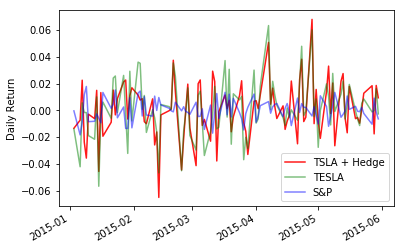

In [45]:
# Get the alpha and beta estimates over the last year
df = pd.DataFrame(get_price_data(param_TSLA))
df.index = df.index.date
df.index = pd.to_datetime(df.index)

start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2015-01-01')

asset = df['Close'].loc[start : end]

df = get_prices_data(params_SPY, period)
df.index = pd.to_datetime(df.index)

start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2015-01-01')

benchmark = df['.INX_Close'].loc[start : end]    

r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
historical_alpha, historical_beta = linreg(X,Y)
print('Asset Historical Estimate (Not Hedged): 2014-01-01 ~ 2015-01-01')
print('alpha: ' + str(historical_alpha))
print('beta: ' + str(historical_beta))
print()

df = pd.DataFrame(get_price_data(param_TSLA))
df.index = df.index.date
df.index = pd.to_datetime(df.index)

start = pd.to_datetime('2015-01-01')
end = pd.to_datetime('2015-06-01')

asset = df['Close'].loc[start : end]

df = get_prices_data(params_SPY, period)
df.index = pd.to_datetime(df.index)

start = pd.to_datetime('2015-01-01')
end = pd.to_datetime('2015-06-01')

benchmark = df['.INX_Close'].loc[start : end]    
# Repeat the process from before to compute alpha and beta for the asset
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
alpha, beta = linreg(X,Y)
print('Asset Out of Sample Estimate(Not Hedged): 2015-01-01 ~ 2015-06-01 ')
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))
print()
# Create hedged portfolio and compute alpha and beta
portfolio = -1*historical_beta*r_b + r_a
P = portfolio.values
alpha, beta = linreg(X,P)
print('Portfolio Out of Sample(Hedged): 2015-01-01 ~ 2015-06-01')
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))
print()

# Plot the returns of the portfolio as well as the asset by itself
portfolio.name = "TSLA + Hedge"
portfolio.plot(alpha=0.9, color='red')
r_a.plot(alpha=0.5, label='TESLA', color='green');
r_b.plot(alpha=0.5, label='S&P', color='blue')
plt.ylabel("Daily Return")
plt.legend();

위에서 보듯이, beta 는 time frame 에 따라 크게 바뀌었고 portfolio 의 beta 를 축소하는데 큰 역할을 못하지만 약 1/2 정도 감소시킬 수는 있었다.